In [1]:
pip install rtree

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import dask.dataframe as dd
import dask.distributed
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points
from scipy.spatial import cKDTree
import copy

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pd.set_option('display.max_rows',10)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth', 200)

In [4]:
gdf_center = gpd.read_file('/content/drive/MyDrive/水道管劣化予測/水道管劣化予測/result/奥州市　重心/gdf_center.shp')

In [5]:
gdf_railway = gpd.read_file('/content/drive/MyDrive/水道管劣化予測/水道管劣化予測/src/国土数値情報/鉄道/N02-22_RailroadSection.shp', encoding='shift-jis') #このデータは道路中心線

In [ ]:
gdf_100m = gpd.read_file('/content/drive/MyDrive/水道管劣化予測/水道管劣化予測/result/奥州市　重心/gdf_osyu_100m_mesh.shp')

In [ ]:
gdf_100m.to_csv('/content/drive/MyDrive/水道管劣化予測/水道管劣化予測/result/確認/奥州市　鉄道　確認/gdf_100m.csv', encoding='shift-jis')

In [ ]:
gdf_railway.to_csv('/content/drive/MyDrive/水道管劣化予測/水道管劣化予測/result/確認/奥州市　鉄道　確認/gdf_railway.csv', encoding='shift-jis')

In [6]:
#座標系を変更
src_proj = 4326 # 変換前の座標系を指定
dst_proj = 6678  # 変換後の座標系を指定
# ポイント（ダムデータ、TransformPointの引数は緯度,経度の順番で指定）
gdf_center.crs = f'epsg:{src_proj}'  # 変換前座標を指定
gdf_center = gdf_center.to_crs(epsg=dst_proj)  # 変換後座標に変換

In [7]:
#座標系を変更
src_proj = 6668 # 変換前の座標系を指定
dst_proj = 6678  # 変換後の座標系を指定
# ポイント（ダムデータ、TransformPointの引数は緯度,経度の順番で指定）
gdf_railway.crs = f'epsg:{src_proj}'  # 変換前座標を指定
gdf_railway = gdf_railway.to_crs(epsg=dst_proj)  # 変換後座標に変換

In [18]:
gdf_railway

,N02_001,N02_002,N02_003,N02_004,geometry
0,23,5,沖縄都市モノレール線,沖縄都市モノレール,"LINESTRING (-1321504.334 -1460975.886, -132147..."
1,12,5,いわて銀河鉄道線,アイジーアールいわて銀河鉄道,"LINESTRING (38918.205 37561.131, 38949.739 375..."
2,12,5,いわて銀河鉄道線,アイジーアールいわて銀河鉄道,"LINESTRING (37625.852 26668.939, 37637.201 266..."
3,12,5,いわて銀河鉄道線,アイジーアールいわて銀河鉄道,"LINESTRING (38553.826 29067.468, 38452.138 288..."
4,12,5,いわて銀河鉄道線,アイジーアールいわて銀河鉄道,"LINESTRING (38899.170 31870.588, 38905.311 318..."
...,...,...,...,...,...
21911,12,5,あいの風とやま鉄道線,あいの風とやま鉄道,"LINESTRING (-321028.489 -358124.867, -320995.6..."
21912,12,5,あいの風とやま鉄道線,あいの風とやま鉄道,"LINESTRING (-320995.609 -358033.901, -320981.0..."
21913,11,2,宗谷線,北海道旅客鉄道,"LINESTRING (130166.275 482301.731, 130164.861 ..."
21914,11,2,札沼線,北海道旅客鉄道,"LINESTRING (50022.159 354402.830, 49818.174 35..."


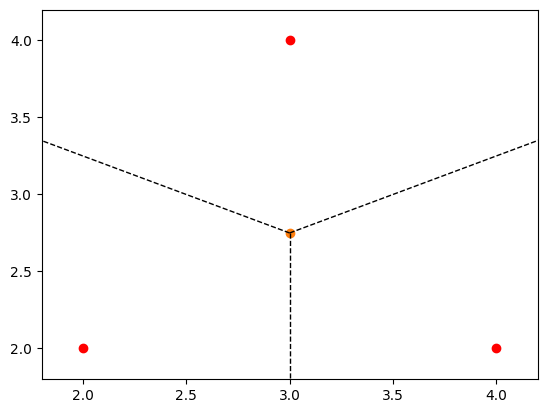

In [17]:
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt

# ポイントデータ
points = np.array([(2, 2), (4, 2), (3, 4)])

# ボロノイ図を計算
vor = Voronoi(points)

# プロット
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax=ax)
ax.plot(points[:, 0], points[:, 1], 'ro')  # ポイントデータを赤色の点として表示
plt.show()

In [15]:
import geopandas as gpd
from shapely.geometry import Point
import rtree

def get_nearest_line_and_distance(point, lines):
    idx = rtree.index.Index()
    for i, line in enumerate(lines.geometry):
        idx.insert(i, line.bounds)

    nearest_distance = float('inf')
    nearest_line = None

    for i in idx.nearest(point.bounds, 1):
        line = lines.geometry[i]
        distance = line.distance(point)
        if distance < nearest_distance:
            nearest_distance = distance
            nearest_line = line

    return nearest_distance, nearest_line

# Create spatial index for lines
sindex = gdf_railway.sindex

# Apply the function to all the points using the spatial index
gdf_center[['nearest_line', 'distance']] = gdf_center.apply(lambda row: get_nearest_line_and_distance(row['geometry'], gdf_railway), axis=1, result_type='expand')

gdf_center.head()


KeyboardInterrupt: ignored

In [16]:
gdf_center

,Meshcode,longitude,latitude,geometry
0,5840378485,140.931875,38.990417,POINT (8536.609 -112073.115)
1,5840378486,140.933125,38.990417,POINT (8644.896 -112072.997)
2,5840378487,140.934375,38.990417,POINT (8753.182 -112072.878)
3,5840378495,140.931875,38.991250,POINT (8536.509 -111980.612)
4,5840378496,140.933125,38.991250,POINT (8644.794 -111980.494)
...,...,...,...,...
101381,5841728323,141.291875,39.318750,POINT (39539.107 -75530.074)
101382,5841728324,141.293125,39.318750,POINT (39646.893 -75529.527)
101383,5841730000,141.375625,39.250417,POINT (46806.199 -83075.847)
101384,5841730001,141.376875,39.250417,POINT (46914.089 -83075.200)


In [13]:
import geopandas as gpd
from shapely.geometry import Point
import rtree

def distance_point_to_line(point, lines):
    # Create an R-tree index for the lines
    idx = rtree.index.Index()
    for i, line in enumerate(lines.geometry):
        idx.insert(i, line.bounds)

    # Find the nearest line using the R-tree index
    nearest_distance = float('inf')
    nearest_line = None

    point_geom = point.geometry
    for i in idx.intersection(point_geom.bounds):
        line = lines.geometry[i]
        distance = line.distance(point_geom)
        if distance < nearest_distance:
            nearest_distance = distance
            nearest_line = line

    return nearest_distance, nearest_line

# Load the point data and line data using GeoPandas
points = gdf_center
lines = gdf_railway

# Iterate over the points and find the nearest line for each point
for point in points.itertuples():
    nearest_distance, nearest_line = distance_point_to_line(point, lines)
    print(f"Point {point.Index}: Nearest Distance: {nearest_distance}, Nearest Line: {nearest_line}")


Point 0: Nearest Distance: inf, Nearest Line: None
Point 1: Nearest Distance: inf, Nearest Line: None
Point 2: Nearest Distance: inf, Nearest Line: None
Point 3: Nearest Distance: inf, Nearest Line: None
Point 4: Nearest Distance: inf, Nearest Line: None
Point 5: Nearest Distance: inf, Nearest Line: None


KeyboardInterrupt: ignored

In [12]:
from tqdm import tqdm

tqdm.pandas()
# Create a spatial index for the lines
sindex = gdf_railway.sindex

# Define a function to get the nearest line for each point and the distance to it using the spatial index
def get_nearest_line_and_distance_with_sindex(row, lines, sindex, buffer=100):
    point = row['geometry']
    # Get the bounding box coordinates of the point and expand it by a buffer
    minx, miny, maxx, maxy = point.bounds
    bbox = (minx - buffer, miny - buffer, maxx + buffer, maxy + buffer)

    # Get the possible matches with the spatial index
    possible_matches_index = list(sindex.intersection(bbox))
    possible_matches = lines.iloc[possible_matches_index]

    # Check if there are no matches
    if possible_matches.empty:
        raise ValueError(f"No lines found within buffer for point {point}")

    # Use the unary_union attribute to create a MultiLineString object
    # This allows us to use the nearest_points function
    nearest_line = nearest_points(point, possible_matches.unary_union)[1]
    distance = point.distance(nearest_line)
    return nearest_line, distance

# Apply the function to all the centroids using the spatial index and the expanded bounding box
# Use a progress bar to track the progress
gdf_center[['nearest_line', 'distance']] = gdf_center.progress_apply(lambda row: get_nearest_line_and_distance_with_sindex(row, gdf_railway['geometry'], sindex, buffer=100000000000), axis=1, result_type='expand')

gdf_center.head()


  0%|          | 175/101386 [01:22<13:19:18,  2.11it/s]


KeyboardInterrupt: ignored

In [ ]:
from tqdm import tqdm

tqdm.pandas()
# Create a spatial index for the lines
sindex = gdf_railway.sindex

# Define a function to get the nearest line for each point and the distance to it using the spatial index
def get_nearest_line_and_distance_with_sindex(point, lines, sindex, buffer=100):
    # Get the bounding box coordinates of the point and expand it by a buffer
    minx, miny, maxx, maxy = point.bounds
    bbox = (minx - buffer, miny - buffer, maxx + buffer, maxy + buffer)

    # Get the possible matches with the spatial index
    possible_matches_index = list(sindex.intersection(bbox))
    possible_matches = lines.iloc[possible_matches_index]

    # Check if there are no matches
    if possible_matches.empty:
        raise ValueError(f"No lines found within buffer for point {point}")

    # Use the unary_union attribute to create a MultiLineString object
    # This allows us to use the nearest_points function
    nearest_line = nearest_points(point, possible_matches.unary_union)[1]
    distance = point.distance(nearest_line)
    return nearest_line, distance

# Apply the function to all the centroids using the spatial index and the expanded bounding box
# Use a progress bar to track the progress
gdf_center[['nearest_line', 'distance']] = gdf_center.progress_apply(lambda row: get_nearest_line_and_distance_with_sindex(row['geometry'], gdf_railway['geometry'], sindex), axis=1, result_type='expand')

gdf_center.head()

  0%|          | 1/101386 [00:04<127:13:00,  4.52s/it]


ValueError: ignored

In [ ]:
import dask.dataframe as dd
from rtree import index
from dask.diagnostics import ProgressBar

# Convert the GeoDataFrame to a Dask DataFrame
ddf_center = dd.from_pandas(gdf_center, npartitions=4)  # adjust npartitions according to your CPU cores

# Define a function to get the nearest line for each point and the distance to it using the spatial index
def get_nearest_line_and_distance_with_sindex(df):
    # Create a spatial index for the railway lines in this partition
    idx = index.Index()
    for i, geometry in enumerate(gdf_railway.geometry):
        idx.insert(i, geometry.bounds)

    result = []
    for row in df.itertuples():
        point = row.geometry
        buffer = 10

        # Get the bounding box coordinates of the point and expand it by a buffer
        minx, miny, maxx, maxy = point.bounds
        bbox = (minx - buffer, miny - buffer, maxx + buffer, maxy + buffer)

        # Get the possible matches with the spatial index
        possible_matches_index = list(idx.intersection(bbox))
        possible_matches = gdf_railway.iloc[possible_matches_index]

        # Check if there are no matches
        if possible_matches.empty:
            result.append((None, None))
            continue

        # Use the unary_union attribute to create a MultiLineString object
        # This allows us to use the nearest_points function
        nearest_line = nearest_points(point, possible_matches.unary_union)[1]
        distance = point.distance(nearest_line)
        result.append((nearest_line, distance))
    return pd.DataFrame(result, columns=['nearest_line', 'distance'])

# Apply the function to all the partitions using the map_partitions function
# Use a progress bar to track the progress
with ProgressBar():
    ddf_result = ddf_center.map_partitions(get_nearest_line_and_distance_with_sindex, meta=('object')).compute(scheduler='processes')

ddf_result.head()


[                                        ] | 0% Completed | 707.38 ms


KeyboardInterrupt: ignored

In [ ]:
import dask.dataframe as dd
import dask_geopandas as dask_gpd
from dask.diagnostics import ProgressBar
from rtree import index

# Convert the GeoDataFrame to a Dask DataFrame
ddf_center = dask_gpd.from_pandas(gdf_center, npartitions=4)  # adjust npartitions according to your CPU cores

# Define a function to get the nearest line for each point and the distance to it using the spatial index
def get_nearest_line_and_distance_with_sindex(df):
    # Create a spatial index for the railway lines in this partition
    idx = index.Index()
    for i, geometry in enumerate(gdf_railway.geometry):
        idx.insert(i, geometry.bounds)

    result = []
    for row in df.itertuples():
        point = row.geometry
        buffer = 10

        # Get the bounding box coordinates of the point and expand it by a buffer
        minx, miny, maxx, maxy = point.bounds
        bbox = (minx - buffer, miny - buffer, maxx + buffer, maxy + buffer)

        # Get the possible matches with the spatial index
        possible_matches_index = list(idx.intersection(bbox))
        possible_matches = gdf_railway.iloc[possible_matches_index]

        # Check if there are no matches
        if possible_matches.empty:
            result.append((None, None))
            continue

        # Use the unary_union attribute to create a MultiLineString object
        # This allows us to use the nearest_points function
        nearest_line = nearest_points(point, possible_matches.unary_union)[1]
        distance = point.distance(nearest_line)
        result.append((nearest_line, distance))
    return pd.DataFrame(result, columns=['nearest_line', 'distance'])

# Apply the function to all the partitions using the map_partitions function
# Use a progress bar to track the progress
with ProgressBar():
    ddf_result = ddf_center.map_partitions(get_nearest_line_and_distance_with_sindex, meta=('object')).compute(scheduler='processes')

ddf_result.head()


AttributeError: ignored

In [ ]:
def get_nearest_line_and_distance(point, lines):
    # Use the unary_union attribute to create a MultiLineString object
    # This allows us to use the nearest_points function
    nearest_line = nearest_points(point, lines.unary_union)[1]
    distance = point.distance(nearest_line)
    return nearest_line, distance

gdf_center[['nearest_line', 'distance']] = gdf_center.apply(lambda row: get_nearest_line_and_distance(row['geometry'], gdf_railway['geometry']), axis=1, result_type='expand')

gdf_center.head()

KeyboardInterrupt: ignored

In [ ]:
# ポイントデータのGeodataframe
point_gdf = gdf_center  # ポイントデータのGeodataframeを指定してください

# ラインデータのGeodataframe
line_gdf = gdf_railway  # ラインデータのGeodataframeを指定してください

# ポイントデータの座標をNumPy配列に変換
point_coords = np.array(point_gdf.geometry.apply(lambda geom: (geom.x, geom.y)).tolist())

# ラインデータの座標をNumPy配列に変換
line_coords = np.array(line_gdf.geometry.apply(lambda geom: geom.coords[0]).tolist())

# 最近傍検索のためのKDTreeを構築
kdtree = cKDTree(line_coords)

# 各ポイントデータの最近傍ラインデータのインデックスと距離を求める
distances, line_indices = kdtree.query(point_coords)

# 最近傍ラインデータのGeodataframeを作成
nearest_lines = line_gdf.iloc[line_indices]

# 距離情報を追加
nearest_lines['distance'] = distances

#結合して変わったindexを変換
nearest_lines.reset_index(drop=True, inplace=True)

# #geometryが二つあると出力できないのでcenter_geometryを削除
gdf_center.drop(columns=['longitude', 'latitude', 'geometry'], axis=1, inplace=True)
nearest_lines.drop('geometry', axis=1, inplace=True)

# 結果の表示
gdf_railway = gdf_center.join(nearest_lines)

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<ipython-input-193-77c4de133f99>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearest_lines.drop('geometry', axis=1, inplace=True)


In [ ]:
#線路のデータフレームのカラム名を変換
gdf_railway.rename(columns={'N02_001': 'Railway_classification', 'N02_002': 'Railway_Business_Type', 'N02_003': 'Railway_route_name', 'N02_004':'Railway_operating_company'}, inplace=True)

In [ ]:
gdf_railway.to_csv('/content/drive/MyDrive/水道管劣化予測/水道管劣化予測/result/奥州市 最近傍鉄道/奥州市_最近傍線路.csv', encoding='shift-jis', index=False)

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
from shapely.ops import nearest_points

# Load the data
df_100m = pd.read_csv('/content/drive/MyDrive/水道管劣化予測/水道管劣化予測/result/確認/奥州市　鉄道　確認/gdf_100m.csv', encoding='cp932')
df_railway = pd.read_csv('/content/drive/MyDrive/水道管劣化予測/水道管劣化予測/result/確認/奥州市　鉄道　確認/gdf_railway.csv', encoding='cp932')

# Convert the 'geometry' column to Shapely objects
df_100m['geometry'] = df_100m['geometry'].apply(wkt.loads)
df_railway['geometry'] = df_railway['geometry'].apply(wkt.loads)

# Convert the DataFrames to GeoDataFrames
gdf_100m = gpd.GeoDataFrame(df_100m, geometry='geometry', crs="EPSG:6668")
gdf_railway = gpd.GeoDataFrame(df_railway, geometry='geometry', crs="EPSG:6668")

# Transform the CRS to EPSG:6678
gdf_100m = gdf_100m.to_crs("EPSG:6678")
gdf_railway = gdf_railway.to_crs("EPSG:6678")

# Calculate the centroids of each polygon
gdf_100m['centroid'] = gdf_100m['geometry'].centroid
gdf_100m.set_geometry('centroid', inplace=True)

# Create a spatial index on gdf_railway
spatial_index = gdf_railway.sindex

def find_nearest(row, spatial_index, gdf2):
    # Find the nearest railway line to the centroid
    nearest_index = spatial_index.nearest(row['geometry'].bounds)
    nearest_geom = nearest_points(row['geometry'], gdf2.loc[nearest_index].geometry.unary_union)[1]

    # Find the distance to the nearest railway line
    distance = row['geometry'].distance(nearest_geom)

    return distance

# Calculate the distance from each centroid to the nearest railway line
gdf_100m['nearest_distance'] = gdf_100m.apply(find_nearest, axis=1, args=(spatial_index, gdf_railway))

gdf_100m.head()

TypeError: ignored

In [ ]:
print(type(gdf_100m['geometry']))
print(type(gdf_railway.geometry.unary_union))

<class 'geopandas.geoseries.GeoSeries'>
<class 'shapely.geometry.multilinestring.MultiLineString'>
